In [1]:
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [3]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [5]:
if not os.path.exists(NEG_PATH):
    os.makedirs(NEG_PATH)

for directory in os.listdir('lfw'):
    sub_dir_path = os.path.join('lfw', directory)
    if os.path.isdir(sub_dir_path): 
        for file in os.listdir(sub_dir_path):
            EX_PATH = os.path.join(sub_dir_path, file)
            if os.path.isfile(EX_PATH):  
                NEW_PATH = os.path.join(NEG_PATH, file)
                os.replace(EX_PATH, NEW_PATH)



In [6]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'/*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'/*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'/*.jpg').take(300)

In [7]:
dir_test = anchor.as_numpy_iterator()
print(dir_test.next())

b'data\\anchor\\9069bff8-4b4b-11ef-b6c8-a243e5a740cd.jpg'


In [8]:
def preprocess(file_path):

    byte_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_img)
    img = tf.image.resize(img, (100,100))
    img = img / 255.0

    return img

1.0


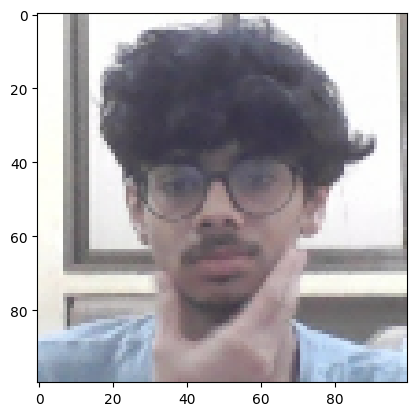

In [9]:
img = preprocess('data/anchor/beb6f9a7-4b4b-11ef-a4d7-a243e5a740cd.jpg')
print(img.numpy().max())
plt.imshow(img)


In [10]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [11]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [12]:

data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [13]:
inp = Input(shape=(100,100,3), name='input_image')

c1 = Conv2D(64, (10,10), activation='relu')(inp)
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

mod = Model(inputs=[inp], outputs=[d1], name='embedding')
mod.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 91, 91, 64)     │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 40, 40, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 17, 17, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │    37,752,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
def make_embedding():
    inp = Input(shape=(100,100,3), name='input_image')


    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)


    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)


    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)


    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)


    return Model(inputs=[inp], outputs=[d1], name='embedding')
embedding = make_embedding()
embedding.summary()


Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 91, 91, 64)     │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 40, 40, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 17, 17, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 6, 6, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │    37,752,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
class L1Dist(Layer):
    def __init__(self, **kwargs):
        super(L1Dist, self).__init__(**kwargs)

    def call(self, input_embedding, validation_embedding):
        input_embedding = tf.convert_to_tensor(input_embedding)
        validation_embedding = tf.convert_to_tensor(validation_embedding)
        return tf.math.abs(input_embedding - validation_embedding)
    
    def compute_output_shape(self, input_shape):
        return input_shape[0]

In [16]:
input_image = Input(name='input_img', shape=(100,100,3))
print(type(input_image))
validation_image = Input(name='validation_img', shape=(100,100,3))
inp_embedding = embedding(input_image)
print(type(inp_embedding))
val_embedding = embedding(validation_image)
siamese_layer = L1Dist()
distances = siamese_layer(inp_embedding, val_embedding)
classifier = Dense(1, activation='sigmoid')(distances)
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')
siamese_network.summary()

<class 'keras.src.backend.common.keras_tensor.KerasTensor'>
<class 'list'>


Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist (L1Dist)    │ (None, 4096)      │          0 │ embedding[0][0],  │
│                     │                   │            │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │      4,097 │ l1_dist[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
def make_siamese_model():

    
    input_image = Input(name='input_img', shape=(100,100,3))

    
    validation_image = Input(name='validation_img', shape=(100,100,3))

    
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))


    classifier = Dense(1, activation='sigmoid')(distances)

    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')
siamese_model = make_siamese_model()
siamese_model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_1 (L1Dist)  │ (None, 4096)      │          0 │ embedding[2][0],  │
│                     │                   │            │ embedding[3][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │      4,097 │ l1_dist_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
binary_cross_loss = tf.losses.BinaryCrossentropy()
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

In [19]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [20]:
test_batch = train_data.as_numpy_iterator()
batch_1 = test_batch.next()
X = batch_1[:2]
y = batch_1[2]
y

array([0., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 0., 1., 0., 1., 0.],
      dtype=float32)

In [21]:
@tf.function
def train_step(batch):

    
    with tf.GradientTape() as tape:
        X = batch[:2]
        y = batch[2]
        yhat = siamese_model(X, training=True)
        yhat = tf.squeeze(yhat, axis=[0, 2])
        loss = binary_cross_loss(y, yhat)
    tf.print(loss)

    grad = tape.gradient(loss, siamese_model.trainable_variables)

    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))

    return loss

In [22]:
def train(data, EPOCHS):
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))

        for idx, batch in enumerate(data):
            train_step(batch)
            progbar.update(idx+1)

        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

In [24]:
EPOCHS = 30
train(train_data, EPOCHS)


 Epoch 1/30
0.319165319
 1/27 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step0.424507439
 2/27 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step0.369520634
 3/27 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step0.419453084
 4/27 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step0.508716702
 5/27 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step0.238754153
 6/27 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step0.319375932
 7/27 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step0.393681526
 8/27 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step0.3527143
 9/27 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step0.321575
10/27 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step0.509737551
11/27 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step0.397255778
12/27 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step0.359836519
13/27 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step0.21325992
14/27 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step0.198948
15/27 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step0.339033425
16/27 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step0.193707675
17/27 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step0.214888841
18/27 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step0.154182062
19/27 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step0.118799075
20/27 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/

In [25]:
import numpy as np
from tensorflow.keras.metrics import Precision, Recall

# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

# Make predictions
y_hat = siamese_model.predict([test_input, test_val])

# Post processing the results: Apply a threshold to convert probabilities to binary values
y_pred = np.where(y_hat > 0.5, 1, 0).flatten()

print(y_true)
print(y_pred)

# Calculate precision and recall
precision = Precision()
recall = Recall()

# Update the state of the metrics
precision.update_state(y_true, y_pred)
recall.update_state(y_true, y_pred)

# Get the result
precision_result = precision.result().numpy()
recall_result = recall.result().numpy()

print(f"Precision: {precision_result}")
print(f"Recall: {recall_result}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step
[0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 1. 1.]
[0 1 1 0 0 0 1 0 0 0 1 0 1 1 1 1]
Precision: 1.0
Recall: 1.0


In [26]:
# Creating a metric object
m = Recall()

# Calculating the recall value
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

# Creating a metric object
m = Precision()

# Calculating the recall value
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()




1.0

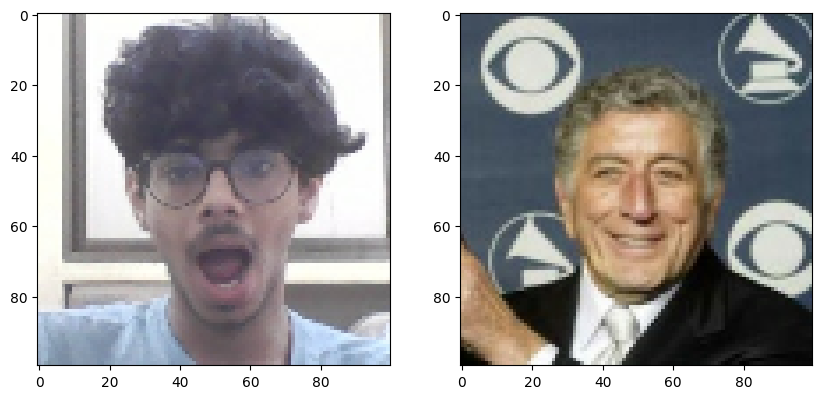

In [27]:
# Set plot size
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[0])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[0])

# Renders cleanly
plt.show()

In [28]:
siamese_model.save('siamesemodel.h5')

In [29]:
# Reload model
model = tf.keras.models.load_model('siamesemodel.h5',
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [30]:
# Make predictions with reloaded model
model.predict([test_input, test_val])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 504ms/step


array([[[2.4198608e-09],
        [1.0000000e+00],
        [9.9999970e-01],
        [6.3723804e-10],
        [1.5432001e-09],
        [7.2835410e-10],
        [9.9999988e-01],
        [3.1862328e-09],
        [3.0800720e-10],
        [1.0396581e-09],
        [9.9999988e-01],
        [3.0335303e-09],
        [1.0000000e+00],
        [1.0000000e+00],
        [9.9999994e-01],
        [9.9999994e-01]]], dtype=float32)

In [31]:

# View model summary
model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_1 (L1Dist)  │ (None, 4096)      │          0 │ embedding[0][0],  │
│                     │                   │            │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │      4,097 │ l1_dist_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [32]:
os.listdir(os.path.join('application_data', 'verification_images'))

['2e6c7997-4b4c-11ef-be7a-a243e5a740cd.jpg',
 '30e10f43-4b4c-11ef-8063-a243e5a740cd.jpg',
 '3203897b-4b4c-11ef-aceb-a243e5a740cd.jpg',
 '321201e7-4b4c-11ef-b93a-a243e5a740cd.jpg',
 '33072733-4b4c-11ef-ba21-a243e5a740cd.jpg',
 '338ef222-4b4c-11ef-b12c-a243e5a740cd.jpg',
 '3430f487-4b4c-11ef-ad53-a243e5a740cd.jpg',
 '348990e4-4b4c-11ef-9e2d-a243e5a740cd.jpg',
 '3567f27a-4b4c-11ef-ad50-a243e5a740cd.jpg',
 '37068ccf-4b4c-11ef-b344-a243e5a740cd.jpg',
 '371497dd-4b4c-11ef-842a-a243e5a740cd.jpg',
 '38117f19-4b4c-11ef-83fc-a243e5a740cd.jpg',
 '390eecbc-4b4c-11ef-9d1e-a243e5a740cd.jpg',
 '3948299b-4b4c-11ef-aba3-a243e5a740cd.jpg',
 '396a000d-4b4c-11ef-8d21-a243e5a740cd.jpg',
 '39785dc9-4b4c-11ef-9e4f-a243e5a740cd.jpg',
 '3a18ab48-4b4c-11ef-a92b-a243e5a740cd.jpg',
 '3a593268-4b4c-11ef-8d52-a243e5a740cd.jpg',
 '3ade8cf5-4b4c-11ef-bd29-a243e5a740cd.jpg',
 '3afae50d-4b4c-11ef-a55e-a243e5a740cd.jpg',
 '3b38fb6f-4b4c-11ef-b7ac-a243e5a740cd.jpg',
 '3b55c9cf-4b4c-11ef-a940-a243e5a740cd.jpg',
 '3bc3643d

In [33]:
for image in os.listdir(os.path.join('application_data', 'verification_images')):
    validation_img = os.path.join('application_data', 'verification_images', image)
    print(validation_img)

application_data\verification_images\2e6c7997-4b4c-11ef-be7a-a243e5a740cd.jpg
application_data\verification_images\30e10f43-4b4c-11ef-8063-a243e5a740cd.jpg
application_data\verification_images\3203897b-4b4c-11ef-aceb-a243e5a740cd.jpg
application_data\verification_images\321201e7-4b4c-11ef-b93a-a243e5a740cd.jpg
application_data\verification_images\33072733-4b4c-11ef-ba21-a243e5a740cd.jpg
application_data\verification_images\338ef222-4b4c-11ef-b12c-a243e5a740cd.jpg
application_data\verification_images\3430f487-4b4c-11ef-ad53-a243e5a740cd.jpg
application_data\verification_images\348990e4-4b4c-11ef-9e2d-a243e5a740cd.jpg
application_data\verification_images\3567f27a-4b4c-11ef-ad50-a243e5a740cd.jpg
application_data\verification_images\37068ccf-4b4c-11ef-b344-a243e5a740cd.jpg
application_data\verification_images\371497dd-4b4c-11ef-842a-a243e5a740cd.jpg
application_data\verification_images\38117f19-4b4c-11ef-83fc-a243e5a740cd.jpg
application_data\verification_images\390eecbc-4b4c-11ef-9d1e-a24

In [34]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

In [35]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 
        hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
        h, s, v = cv2.split(hsv)

        lim = 255 - 10
        v[v > lim] = 255
        v[v <= lim] -= 10
    
        final_hsv = cv2.merge((h, s, v))
        img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)

        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(siamese_model, 0.5, 0.5)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━

In [36]:

np.sum(np.squeeze(results) > 0.9)

51

In [37]:
results

[array([[[0.99995047]]], dtype=float32),
 array([[[0.9999935]]], dtype=float32),
 array([[[0.9999327]]], dtype=float32),
 array([[[0.9997393]]], dtype=float32),
 array([[[0.9999952]]], dtype=float32),
 array([[[0.9999703]]], dtype=float32),
 array([[[0.99999475]]], dtype=float32),
 array([[[0.9999949]]], dtype=float32),
 array([[[0.9999962]]], dtype=float32),
 array([[[0.9999758]]], dtype=float32),
 array([[[0.99997216]]], dtype=float32),
 array([[[0.99999106]]], dtype=float32),
 array([[[0.99999803]]], dtype=float32),
 array([[[0.99999547]]], dtype=float32),
 array([[[0.99999094]]], dtype=float32),
 array([[[0.9999876]]], dtype=float32),
 array([[[0.9999988]]], dtype=float32),
 array([[[0.9999983]]], dtype=float32),
 array([[[0.99999636]]], dtype=float32),
 array([[[0.99999857]]], dtype=float32),
 array([[[0.9999896]]], dtype=float32),
 array([[[0.9999936]]], dtype=float32),
 array([[[0.99999297]]], dtype=float32),
 array([[[0.99988866]]], dtype=float32),
 array([[[0.99992925]]], dtyp